# Forecasting

This notebook develops and evaluates time series forecasting models for daily household energy consumption, building on insights from exploratory data analysis in order to generate accurate short-term forecasts of energy consumption, most notably the energy consumption on a day given all information prior to that day.

In [1]:
import pandas as pd
import numpy as np
import import_ipynb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from aggregate_data import aggregate_daily_data
from statsmodels.tsa.statespace.sarimax import SARIMAX

data = pd.read_csv("household_power_consumption.txt", sep=";", na_values="?", low_memory=False)
daily_data = aggregate_daily_data(data)
df = daily_data.copy()

## 1. Baseline Forecast

A simple baseline model is used as a performance reference. This establishes a minimum standard that more complex models must outperform.


In [2]:
df["y_next"] = df["Global_active_power_kWh"].shift(-1)

for lag in [1,2,7,14]:
    df[f"lag_{lag}"] = df["Global_active_power_kWh"].shift(lag)
    
df["dow"] = df.index.dayofweek
df["is_weekend"] = (df["dow"] >=5 ).astype(int)

model_df = df.dropna().copy()
X = model_df[[f"lag_{lag}" for lag in [1,2,7,14]] + ["dow", "is_weekend"]]
y = model_df["y_next"]

split_idx = int(len(model_df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

y_pred_naive = X_test["lag_1"]

mae = mean_absolute_error(y_test, y_pred_naive)
mse = mean_squared_error(y_test, y_pred_naive)
rmse = np.sqrt(mse)

print(f"Naive baseline (y_hat = y_t)  MAE: {mae:.3f}  RMSE: {rmse:.3f}")

y_pred_snaive = X_test["lag_7"]
mae_s = mean_absolute_error(y_test, y_pred_snaive)
mse_s = mean_squared_error(y_test, y_pred_snaive)
rmse_s = np.sqrt(mse_s)
print(f"Seasonal naive (y_hat = y_(t-7)) MAE: {mae_s:.3f}  RMSE: {rmse_s:.3f}")

Naive baseline (y_hat = y_t)  MAE: 5.761  RMSE: 8.081
Seasonal naive (y_hat = y_(t-7)) MAE: 7.222  RMSE: 9.826


## 2. Baseline and Autoregressive Model Evaluation

This section compares simple baseline and autoregressive models for daily energy consumption forecasting. We start with naive lag-based baselines (e.g., lag 1 and lag 7) to establish performance benchmarks. We then fit autoregressive models via linear regression using increasing sets of lagged features, and finally include calendar effects (day of week and weekend indicators). Models are evaluated on the test set using MAE and RMSE, with results summarized and sorted by MAE.

In [3]:
def eval_forecast(y_true, y_pred, name="model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return pd.Series({"model": name, "MAE": mae, "RMSE": rmse})

results = []
results.append(eval_forecast(y_test, X_test["lag_1"], "Naive (lag_1)"))
results.append(eval_forecast(y_test, X_test["lag_7"], "Naive (lag_7)"))

def fit_lr(cols, name):
    lr = LinearRegression()
    lr.fit(X_train[cols], y_train)
    y_pred = lr.predict(X_test[cols])
    return eval_forecast(y_test, y_pred, name), lr

r, lr_ar1 = fit_lr(["lag_1"], "AR (1) via LR [lag_1]")
results.append(r)

r, lr_ar7 = fit_lr(["lag_7"], "AR(7) via LR [lag_7]")
results.append(r)

r, lr_ar17 = fit_lr(["lag_1", "lag_7"], "AR(1,7) via LR [lag_1, lag_7]")
results.append(r)

r, lr_ar_all = fit_lr(["lag_1", "lag_2", "lag_7", "lag_14"], "AR lags [1,2,7,14]")
results.append(r)

r, lr_ar_cal = fit_lr(["lag_1", "lag_2", "lag_7", "lag_14", "dow", "is_weekend"],
                      "AR lags + calendar")
results.append(r)

results_df = pd.DataFrame(results).sort_values("MAE")
results_df

,model,MAE,RMSE
5,"AR lags [1,2,7,14]",5.270106,7.106887
6,AR lags + calendar,5.324536,7.144771
4,"AR(1,7) via LR [lag_1, lag_7]",5.377647,7.166518
2,AR (1) via LR [lag_1],5.483077,7.262262
0,Naive (lag_1),5.761031,8.081184
3,AR(7) via LR [lag_7],6.226501,8.133059
1,Naive (lag_7),7.222390,9.826409


## 3. Residual Diagnostics for the Selected Autoregressive Model

This section examines residuals from the best-performing autoregressive model to better understand its error structure. Summary statistics are computed to assess bias, dispersion, and typical forecast error.

The residual mean is close to zero, indicating minimal systematic bias in the model’s predictions. However, the residual standard deviation and error metrics (MAE and RMSE) show that substantial variability remains unexplained. This suggests that while the model captures short-term dependence effectively, it struggles during higher-variance periods and peak consumption days.

To further evaluate model adequacy, the autocorrelation function (ACF) of the residuals is examined to assess whether significant temporal dependence remains after modeling.

Residual mean: -0.9373009069811847
Residual std: 7.0571559235357695
Residual MAE: 5.270106390880065
Residual RMSE: 7.106887137362464


<Figure size 640x480 with 0 Axes>

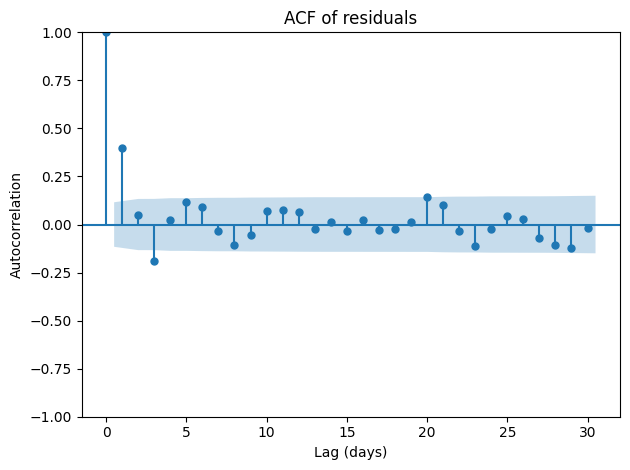

In [4]:
best_cols = ["lag_1", "lag_2", "lag_7", "lag_14"]
lr = LinearRegression()
lr.fit(X_train[best_cols], y_train)
y_pred = lr.predict(X_test[best_cols])
resid = y_test.values - y_pred
resid_s = pd.Series(resid, index=y_test.index, name="residuals")

print("Residual mean:", resid_s.mean())
print("Residual std:", resid_s.std(ddof=1))
print("Residual MAE:", np.mean(np.abs(resid_s.values)))
print("Residual RMSE:", np.sqrt(np.mean(resid_s.values**2)))

# Residual ACF
plt.figure()
plot_acf(resid_s, lags=30)
plt.title("ACF of residuals")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

## 4. Predicted vs Actual on the Test Set

This plot overlays the model’s forecast against the true daily energy consumption over the test period to visually assess performance. Relative to the naive benchmarks (MAE 5.761 / RMSE 8.081) and the seasonal naive baseline (MAE 7.222 / RMSE 9.826), the selected AR model shows improved accuracy (residual MAE ≈ 5.27, RMSE ≈ 7.11).

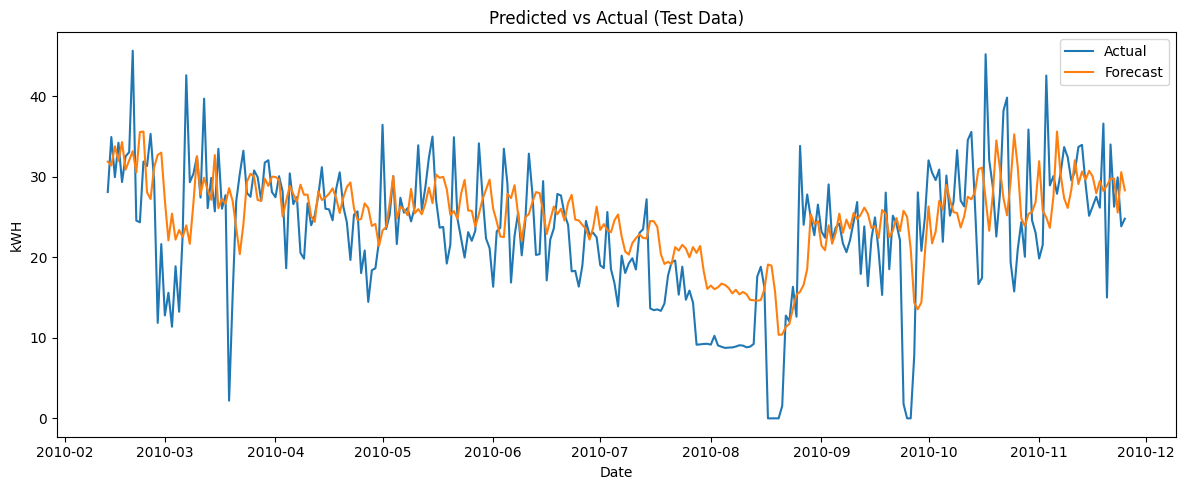

In [5]:
y_pred_corrected = -(resid_s.mean()) + y_pred
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(y_test.index, y_test.values, label="Actual")
ax.plot(y_test.index, y_pred_corrected, label="Forecast")
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(ax.xaxis.get_major_locator()))
ax.set_xlabel("Date")
ax.set_ylabel("kWH")
ax.set_title("Predicted vs Actual (Test Data)")
ax.legend()

plt.tight_layout()
plt.show()

## 5. SARIMAX with Calendar Features

In order to see if any improvement can be made, calendar-based features are introduced as exogenous variables in a SARIMAX model. These features encode systematic behavioral patterns such as weekdays versus weekends and monthly structure, which may influence household energy consumption independently of recent usage history. The goal is to assess whether incorporating simple, forecast-available calendar information improves predictive performance relative to the pure time-series benchmark.


In [7]:
def make_calendar_features(index: pd.DatetimeIndex) -> pd.DataFrame:
    X = pd.DataFrame(index=index)

    X["is_weekend"] = (index.dayofweek >= 5).astype(int)

    X = pd.get_dummies(
        X.assign(dow=index.dayofweek),
        columns=["dow"],
        drop_first=True
    )

    X = pd.get_dummies(
        X.assign(month=index.month),
        columns=["month"],
        drop_first=True
    )

    return X.astype(float)

X = make_calendar_features(y.index)

test_days = 90
y_train, y_test = y.iloc[:-test_days], y.iloc[-test_days:]
X_train, X_test = X.loc[y_train.index], X.loc[y_test.index]

# SARIMAX specification
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 7)

sarimax = SARIMAX(
    y_train,
    exog=X_train,
    order=order,
    seasonal_order=seasonal_order,
    trend="n",
    enforce_stationarity=True,
    enforce_invertibility=True
).fit(disp=False, maxiter=1000)

y_pred = sarimax.get_forecast(
    steps=len(y_test),
    exog=X_test
).predicted_mean

mae = float(np.mean(np.abs(y_test - y_pred)))
rmse = float(np.sqrt(np.mean((y_test - y_pred) ** 2)))

print(f"SARIMAX (calendar) MAE: {mae:.3f}")
print(f"SARIMAX (calendar) RMSE: {rmse:.3f}")

SARIMAX (calendar) MAE: 5.403
SARIMAX (calendar) RMSE: 7.543


## 6. Conclusion and Lessons Learned

This project explored daily household energy consumption forecasting through a sequence of models with increasing structural assumptions. Exploratory analysis revealed strong weekly seasonality, short-lag dependence, and higher variance on weekends, motivating the use of both lag-based features and calendar information.

Initial baseline models using historical consumption patterns achieved the best overall predictive performance, particularly in terms of MAE and RMSE. While these models were relatively simple, they proved effective at capturing short-term dependence in daily energy usage.

A SARIMAX model incorporating calendar-based exogenous features was subsequently evaluated to test whether explicitly modeling seasonal dynamics and behavioral calendar effects would improve forecast accuracy. Although this approach reduced error relative to naïve seasonal baselines, it did not outperform the earlier feature-based models. This suggests that the additional structure imposed by the SARIMAX framework may have introduced bias or over-smoothing that limited its ability to adapt to high-variance days.

These results highlight an important practical insight: more complex time series models do not necessarily yield better forecasts, particularly when simpler models already capture the dominant short-term patterns in the data. While calendar effects explain some systematic variation, the strongest predictive signal in this dataset appears to come from recent historical consumption rather than seasonal dynamics alone.

Overall, this project demonstrates the value of benchmarking multiple modeling approaches, diagnosing failure modes, and prioritizing empirical performance over model complexity. Future work could explore alternative ways of incorporating calendar information or lagged appliance-level features while carefully avoiding data leakage.
